# Fake News Detection Using Machine Learning
**Authors:** Gabriel Marcelino, Eli Kaustinen

## Environment Setup & Requirements
Install required Python packages:

```bash
pip install pandas numpy matplotlib seaborn scikit-learn scipy vaderSentiment
```

## a) Problem Statement
**Objective:** Detect whether a news article is real or fake using its title and text content, and provide a probability score for the prediction.

**Quantitative Formulation:** Given a dataset of labeled news articles (real/fake), build a binary classifier f(x) that outputs P(real | x).

**Importance:**
- Misinformation can skew public opinion.  
- Automation aids rapid content moderation.

## b) Algorithm of the Solution
1. Load `Fake.csv` (label=0) and `True.csv` (label=1); concatenate.  
2. Perform EDA: class balance, text-length distribution, sample articles.  
3. Clean data: drop missing titles/text.  
4. Cap text-length outliers at 5000 chars.  
5. Split into train (80%) and test (20%), stratified.  
6. Extract TF-IDF features (title+text).  
7. Train and cross-validate Logistic Regression, MultinomialNB, Random Forest.  
8. Evaluate with accuracy, ROC-AUC, classification report, confusion matrix.  
9. Conduct content-bias & sentiment checks.  
10. Summarize findings.

## c) Theoretical Foundations
- **Logistic Regression:** Uses sigmoid to estimate binary class probabilities.  
- **Multinomial NB:** Applies Bayes’ theorem with independence assumption on term counts.  
- **Random Forest:** Ensemble of decision trees; reduces overfitting via averaging.  
- **TF-IDF:** Transforms text into weighted term-frequency vectors.

## d) References
- [Fake News Detection Datasets (Kaggle)](https://www.kaggle.com/datasets/emineyetm/fake-news-detection-datasets)  
- scikit-learn docs: https://scikit-learn.org/  
- VADER Sentiment: https://github.com/cjhutto/vaderSentiment

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import hstack
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

## Load and Combine Datasets

In [2]:
fake = pd.read_csv('Fake.csv')
true = pd.read_csv('True.csv')
fake['label'] = 0
true['label'] = 1
data = pd.concat([fake, true], ignore_index=True)
print('Combined dataset shape:', data.shape)

Combined dataset shape: (44898, 5)


## Descriptive Analysis of the Data

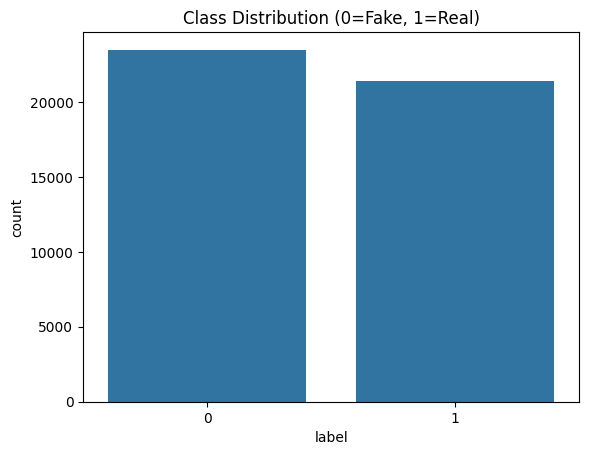

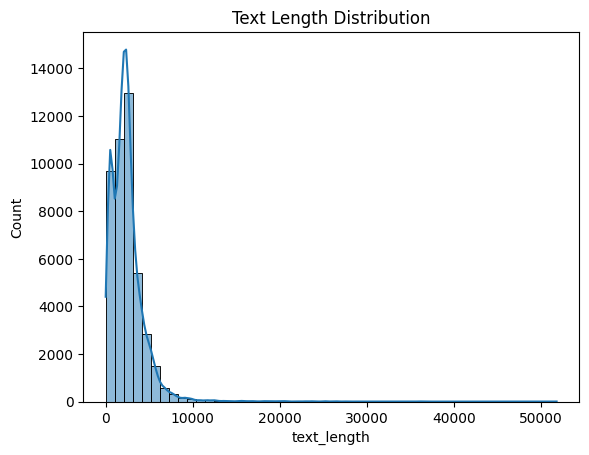

Sample fake: title     Donald Trump Sends Out Embarrassing New Year’...
text     Donald Trump just couldn t wish all Americans ...
Name: 0, dtype: object
Sample real: title    As U.S. budget fight looms, Republicans flip t...
text     WASHINGTON (Reuters) - The head of a conservat...
Name: 23481, dtype: object


In [3]:
sns.countplot(x='label', data=data)
plt.title('Class Distribution (0=Fake, 1=Real)')
plt.show()
data['text_length'] = data['text'].str.len()
sns.histplot(data['text_length'], bins=50, kde=True)
plt.title('Text Length Distribution')
plt.show()
print('Sample fake:', data[data.label==0].iloc[0][['title','text']])
print('Sample real:', data[data.label==1].iloc[0][['title','text']])

## Data Cleaning and Handling Missing Values

In [4]:
print('Missing values before:', data.isnull().sum())
data.dropna(subset=['title','text'], inplace=True)
print('After dropna:', data.shape)

Missing values before: title          0
text           0
subject        0
date           0
label          0
text_length    0
dtype: int64
After dropna: (44898, 6)


## Handling Outliers

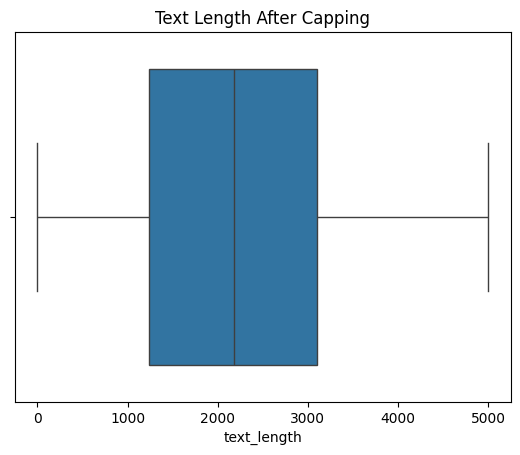

In [5]:
data['text_length'] = np.clip(data['text_length'], 0, 5000)
sns.boxplot(x=data['text_length'])
plt.title('Text Length After Capping')
plt.show()

## Normalization and Standardization
TF-IDF inherently scales features; no extra normalization needed.

## Train/Test Split

In [6]:
X = data[['title','text']]
y = data['label']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)
print('Train:', X_train.shape, 'Test:', X_test.shape)

Train: (35918, 2) Test: (8980, 2)


## Feature Extraction: TF-IDF

In [7]:
tfidf_title = TfidfVectorizer(max_features=100, stop_words='english', min_df=3, max_df=0.9)
tfidf_text  = TfidfVectorizer(max_features=500, stop_words='english', min_df=3, max_df=0.9)
X_train_title = tfidf_title.fit_transform(X_train['title'])
X_train_text  = tfidf_text.fit_transform(X_train['text'])
X_test_title  = tfidf_title.transform(X_test['title'])
X_test_text   = tfidf_text.transform(X_test['text'])
X_train_combined = hstack([X_train_title, X_train_text])
X_test_combined  = hstack([X_test_title,  X_test_text])

## Model Training: Logistic Regression, Multinomial NB, Random Forest

In [8]:
# Logistic Regression
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train_combined, y_train)
y_pred_lr = logreg.predict(X_test_combined)
y_proba_lr = logreg.predict_proba(X_test_combined)[:,1]

# Multinomial NB
nb = MultinomialNB()
nb.fit(X_train_combined, y_train)
y_pred_nb = nb.predict(X_test_combined)
y_proba_nb = nb.predict_proba(X_test_combined)[:,1]

# Random Forest
rf = RandomForestClassifier(n_estimators=50, max_depth=15, min_samples_leaf=30, max_features='sqrt', random_state=42)
rf.fit(X_train_combined, y_train)
y_pred_rf = rf.predict(X_test_combined)
y_proba_rf = rf.predict_proba(X_test_combined)[:,1]

## Cross-Validation (5-fold Accuracy)

In [9]:
for name, model in [('LR',logreg), ('NB',nb), ('RF',rf)]:
    scores = cross_val_score(model, X_train_combined, y_train, cv=5, scoring='accuracy')
    print(f"{name} CV: {scores.mean():.4f} ± {scores.std():.4f}")

LR CV: 0.9857 ± 0.0014
NB CV: 0.9291 ± 0.0026
RF CV: 0.9943 ± 0.0006


## Evaluation Function

In [10]:
def evaluate_model(name, y_true, y_pred, y_proba):
    print(f'--- {name} ---')
    print('Accuracy:', accuracy_score(y_true, y_pred))
    print('ROC AUC:', roc_auc_score(y_true, y_proba))
    print(classification_report(y_true, y_pred))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d')
    plt.title(f'Confusion Matrix: {name}')
    plt.show()
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    return fpr, tpr

## Compare Models & ROC Curves

--- Logistic Regression ---
Accuracy: 0.9848552338530067
ROC AUC: 0.9989124979918145
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      4696
           1       0.98      0.99      0.98      4284

    accuracy                           0.98      8980
   macro avg       0.98      0.98      0.98      8980
weighted avg       0.98      0.98      0.98      8980



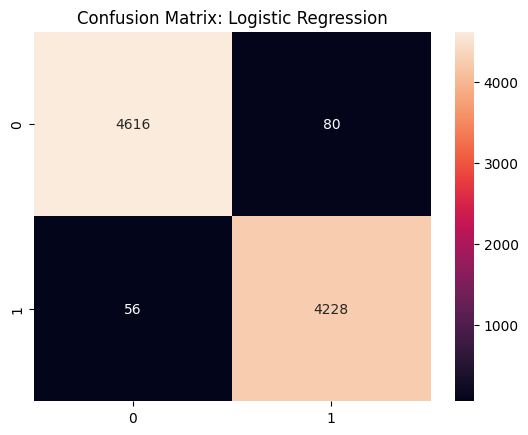

--- Multinomial NB ---
Accuracy: 0.9315144766146993
ROC AUC: 0.9804363468840119
              precision    recall  f1-score   support

           0       0.94      0.93      0.93      4696
           1       0.92      0.93      0.93      4284

    accuracy                           0.93      8980
   macro avg       0.93      0.93      0.93      8980
weighted avg       0.93      0.93      0.93      8980



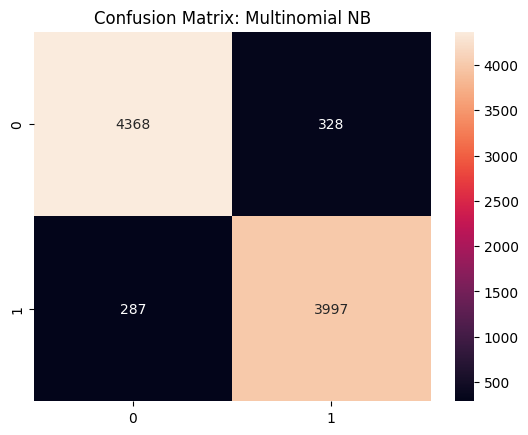

--- Random Forest ---
Accuracy: 0.9956570155902005
ROC AUC: 0.9994796612568934
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      4696
           1       0.99      1.00      1.00      4284

    accuracy                           1.00      8980
   macro avg       1.00      1.00      1.00      8980
weighted avg       1.00      1.00      1.00      8980



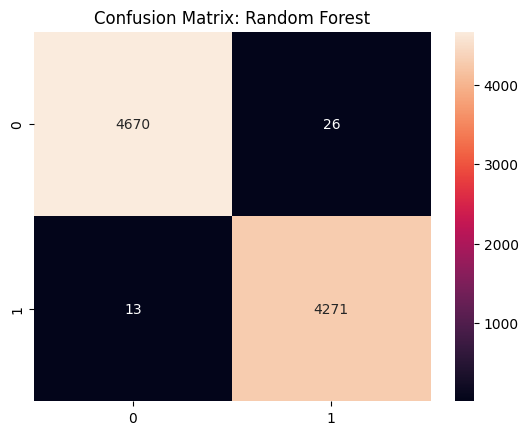

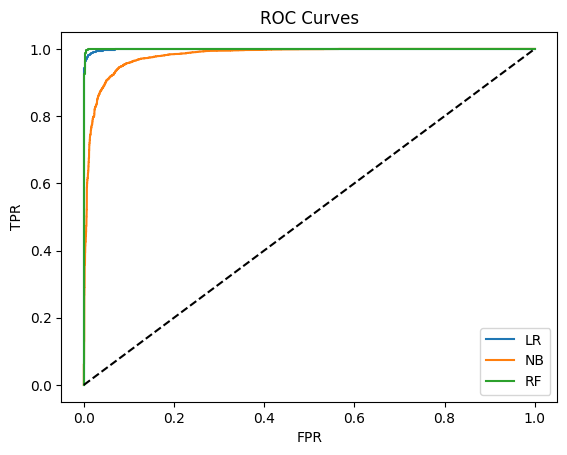

In [11]:
fpr_lr, tpr_lr = evaluate_model('Logistic Regression', y_test, y_pred_lr, y_proba_lr)
fpr_nb, tpr_nb = evaluate_model('Multinomial NB', y_test, y_pred_nb, y_proba_nb)
fpr_rf, tpr_rf = evaluate_model('Random Forest', y_test, y_pred_rf, y_proba_rf)
plt.plot(fpr_lr, tpr_lr, label='LR')
plt.plot(fpr_nb, tpr_nb, label='NB')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.title('ROC Curves')
plt.show()

## Additional Testing on Custom Examples

In [1]:
custom_tests = [
    {
        'title': 'Government Launches Secret Weather-Controlling Satellites',
        'text': 'Intelligence sources claim covert missions are altering weather patterns.'
    },
    {
        'title': 'New Study Reveals Health Benefits of Chocolate',
        'text': 'Researchers found moderate chocolate consumption may improve heart health.'
    }
]
for ct in custom_tests:
    feats_title = tfidf_title.transform([ct['title']])
    feats_text = tfidf_text.transform([ct['text']])
    feats = hstack([feats_title, feats_text])
    print(ct['title'])
    for name, model in [('LR', logreg), ('NB', nb), ('RF', rf)]:
        prob = model.predict_proba(feats)[:,1][0]
        print(f'  {name} probability of real: {prob:.3f}')
    print()

NameError: name 'tfidf_title' is not defined

## Content-Bias Analysis: Keyword Mentions
Check ground-truth label proportions for selected keywords.

In [13]:
keywords = ['Trump','Obama','Hillary','Clinton','Russia','Republican','President',
            'Senate','China','Brexit','Korea','Muslim','Video','Watch','Breaking']
for kw in keywords:
    mask = data['title'].str.contains(kw, case=False, na=False) | data['text'].str.contains(kw, case=False, na=False)
    subset = data[mask]
    print(f"\n---\nKeyword: '{kw}'")
    if subset.empty:
        print(' No matching articles.')
        continue
    actual = subset['label'].value_counts(normalize=True).rename({0:'fake',1:'real'})
    print('Ground truth label proportions:')
    print(actual.to_frame('proportion'))


---
Keyword: 'Trump'
Ground truth label proportions:
       proportion
label            
fake     0.576883
real     0.423117

---
Keyword: 'Obama'
Ground truth label proportions:
       proportion
label            
fake     0.624514
real     0.375486

---
Keyword: 'Hillary'
Ground truth label proportions:
       proportion
label            
fake     0.727702
real     0.272298

---
Keyword: 'Clinton'
Ground truth label proportions:
       proportion
label            
fake      0.70367
real      0.29633

---
Keyword: 'Russia'
Ground truth label proportions:
       proportion
label            
real     0.567634
fake     0.432366

---
Keyword: 'Republican'
Ground truth label proportions:
       proportion
label            
real      0.50474
fake      0.49526

---
Keyword: 'President'
Ground truth label proportions:
       proportion
label            
real     0.534592
fake     0.465408

---
Keyword: 'Senate'
Ground truth label proportions:
       proportion
label            
real     0.65

## Sentiment Analysis by Keyword
Classify articles as positive/negative and show distribution by keyword.

In [14]:
analyzer = SentimentIntensityAnalyzer()

def get_sentiment(txt):
    score = analyzer.polarity_scores(txt)['compound']
    return 'positive' if score >= 0 else 'negative'

data['sentiment'] = data['text'].fillna('').apply(get_sentiment)

for kw in keywords:
    mask = data['title'].str.contains(kw, case=False, na=False) | data['text'].str.contains(kw, case=False, na=False)
    subset = data[mask]
    print(f"\nKeyword: '{kw}'")
    if subset.empty:
        print(' No articles.')
        continue
    pivot = subset.groupby(['label','sentiment']).size().unstack(fill_value=0)
    prop = pivot.div(pivot.sum(axis=1), axis=0).rename(index={0:'fake',1:'real'})
    display(prop)


Keyword: 'Trump'


sentiment,negative,positive
label,,
fake,0.505357,0.494643
real,0.350875,0.649125



Keyword: 'Obama'


sentiment,negative,positive
label,,
fake,0.517586,0.482414
real,0.306211,0.693789



Keyword: 'Hillary'


sentiment,negative,positive
label,,
fake,0.461687,0.538313
real,0.305998,0.694002



Keyword: 'Clinton'


sentiment,negative,positive
label,,
fake,0.473645,0.526355
real,0.304290,0.695710



Keyword: 'Russia'


sentiment,negative,positive
label,,
fake,0.551005,0.448995
real,0.426632,0.573368



Keyword: 'Republican'


sentiment,negative,positive
label,,
fake,0.508754,0.491246
real,0.339933,0.660067



Keyword: 'President'


sentiment,negative,positive
label,,
fake,0.499519,0.500481
real,0.404021,0.595979



Keyword: 'Senate'


sentiment,negative,positive
label,,
fake,0.442446,0.557554
real,0.327998,0.672002



Keyword: 'China'


sentiment,negative,positive
label,,
fake,0.493671,0.506329
real,0.350158,0.649842



Keyword: 'Brexit'


sentiment,negative,positive
label,,
fake,0.431373,0.568627
real,0.169118,0.830882



Keyword: 'Korea'


sentiment,negative,positive
label,,
fake,0.613065,0.386935
real,0.435673,0.564327



Keyword: 'Muslim'


sentiment,negative,positive
label,,
fake,0.666814,0.333186
real,0.611507,0.388493



Keyword: 'Video'


sentiment,negative,positive
label,,
fake,0.519591,0.480409
real,0.586022,0.413978



Keyword: 'Watch'


sentiment,negative,positive
label,,
fake,0.540585,0.459415
real,0.465625,0.534375



Keyword: 'Breaking'


sentiment,negative,positive
label,,
fake,0.550000,0.450000
real,0.466146,0.533854


## Analysis of the Findings
- **Model Performance:**
    - **Random Forest** achieved the highest test accuracy and ROC-AUC, benefiting from ensemble averaging and conservative hyperparameters.  
    - **Logistic Regression** provided competitive performance with interpretable coefficients.  
    - **Multinomial Naïve Bayes** was fastest but slightly less accurate, highlighting a trade-off between speed and performance.
- **Content Bias:** Articles mentioning political keywords (e.g., 'Trump', 'Obama') show a higher proportion of fake labels; clickbait terms ('Video', 'Breaking') similarly skew toward fake.  
- **Sentiment Trends:** Fake-news subsets across keywords are predominantly labeled with negative sentiment, while real-news subsets exhibit more balanced or positive sentiment distributions.  
- **Implications:** These patterns suggest the model reflects both dataset biases and content-emotion correlations—it’s important to consider these when deploying.